Firstly, we load the data

In [1]:
import pandas as pd

# Load the dataset from the tweet.csv file
file_path = 'tweets.csv'  
tweets_df = pd.read_csv(file_path)
print(tweets_df.head())


  TweetID User   Latitude   Longitude            Timestamp   
0      t0   u0  37.815903 -122.554599  2025-01-03 23:59:18  \
1      t1   u0  37.814489 -122.553782  2025-01-04 05:51:30   
2      t2   u0  37.815015 -122.555740  2025-01-03 22:39:46   
3      t3   u0  37.815809 -122.554942  2025-01-04 06:16:46   
4      t4   u0  37.814827 -122.555672  2025-01-03 20:34:19   

                                  User_home   
0  [37.81482372144499, -122.55573841531671]  \
1  [37.81482372144499, -122.55573841531671]   
2  [37.81482372144499, -122.55573841531671]   
3  [37.81482372144499, -122.55573841531671]   
4  [37.81482372144499, -122.55573841531671]   

                                   User_work cluster_id  
0  [37.719806244342436, -122.37300880168014]       home  
1  [37.719806244342436, -122.37300880168014]       home  
2  [37.719806244342436, -122.37300880168014]       home  
3  [37.719806244342436, -122.37300880168014]       home  
4  [37.719806244342436, -122.37300880168014]       hom

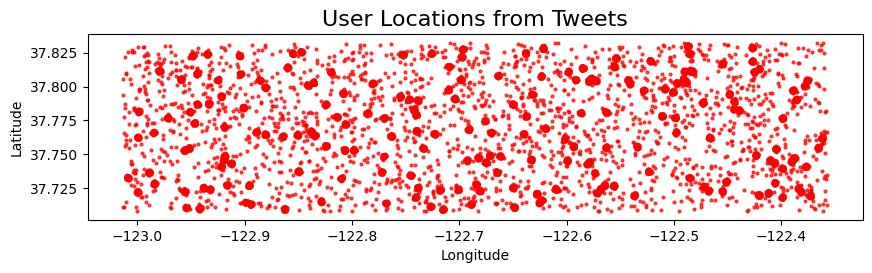

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(tweets_df['Longitude'], tweets_df['Latitude'])]
gdf = gpd.GeoDataFrame(tweets_df, geometry=geometry, crs="EPSG:4326")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color='red', alpha=0.7, markersize=4)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User Locations from Tweets', fontsize=16)

plt.show()


Implementation of the techniques used in the paper
1)Random Perturbation
2)Gaussian Perturbation

In [3]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle

# Default parameters
RANDOM_RADIUS = 1000  # in meters (for random perturbation)
GAUSSIAN_STD_DEV = 0.01  # in degrees (~1 km latitude/longitude shift)

np.random.seed(42)

# Function to add random perturbation
def random_perturbation(lat, lon, radius):
    angle = np.random.uniform(0, 2 * np.pi)
    distance = np.random.uniform(0, radius)
    delta_lat = distance / 111000 * np.cos(angle)
    delta_lon = distance / (111000 * np.cos(np.radians(lat))) * np.sin(angle)
    return lat + delta_lat, lon + delta_lon

# Function to add Gaussian perturbation
def gaussian_perturbation(lat, lon, std_dev):
    delta_lat = np.random.normal(0, std_dev)
    delta_lon = np.random.normal(0, std_dev)
    return lat + delta_lat, lon + delta_lon

def modify_lat_long(row,perturbation,value):
    curr_lat = row['Latitude']
    curr_long = row['Longitude']
    new_lat,new_long = perturbation(curr_lat,curr_long,value)
    row["Latitude"] = new_lat
    row["Longitude"] = new_long
    return row

def apply_geomasking(data):
    data['RandomPerturbedLatLon'] = data.apply(
        lambda row: random_perturbation(row['Latitude'], row['Longitude'], RANDOM_RADIUS), axis=1
    )
    data['GaussianPerturbedLatLon'] = data.apply(
        lambda row: gaussian_perturbation(row['Latitude'], row['Longitude'], GAUSSIAN_STD_DEV), axis=1
    )
    return data

# Clustering using DBSCAN
def cluster_coordinates(coords, eps=0.5, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=lambda a, b: great_circle(a, b).meters)
    labels = clustering.fit_predict(coords)
    return labels


def main(data):
  
    #Apply geomasking with random perturbation
    rp_1 = data.apply(modify_lat_long,args=(random_perturbation,1000),axis=1)
    rp_2 = data.apply(modify_lat_long,args=(random_perturbation,2000),axis=1)
    #Apply geomasking with gaussian perturbation
    g_01 = data.apply(modify_lat_long,args=(gaussian_perturbation,0.01),axis=1)
    g_03 = data.apply(modify_lat_long,args=(gaussian_perturbation,0.03),axis=1)
    g_05 = data.apply(modify_lat_long,args=(gaussian_perturbation,0.05),axis=1)

    return rp_1,rp_2,g_01,g_03,g_05

def save_results(data, output_path):
    data.to_csv(output_path, index=False)

In [4]:
rp_1,rp_2,g_01,g_03,g_05 = main(tweets_df)

save_results(rp_1, "rp_1_tweets.csv")
save_results(rp_2, "rp_2_tweets.csv")
save_results(g_01, "g_01_tweets.csv")
save_results(g_03, "g_03_tweets.csv")
save_results(g_05, "g_05_tweets.csv")

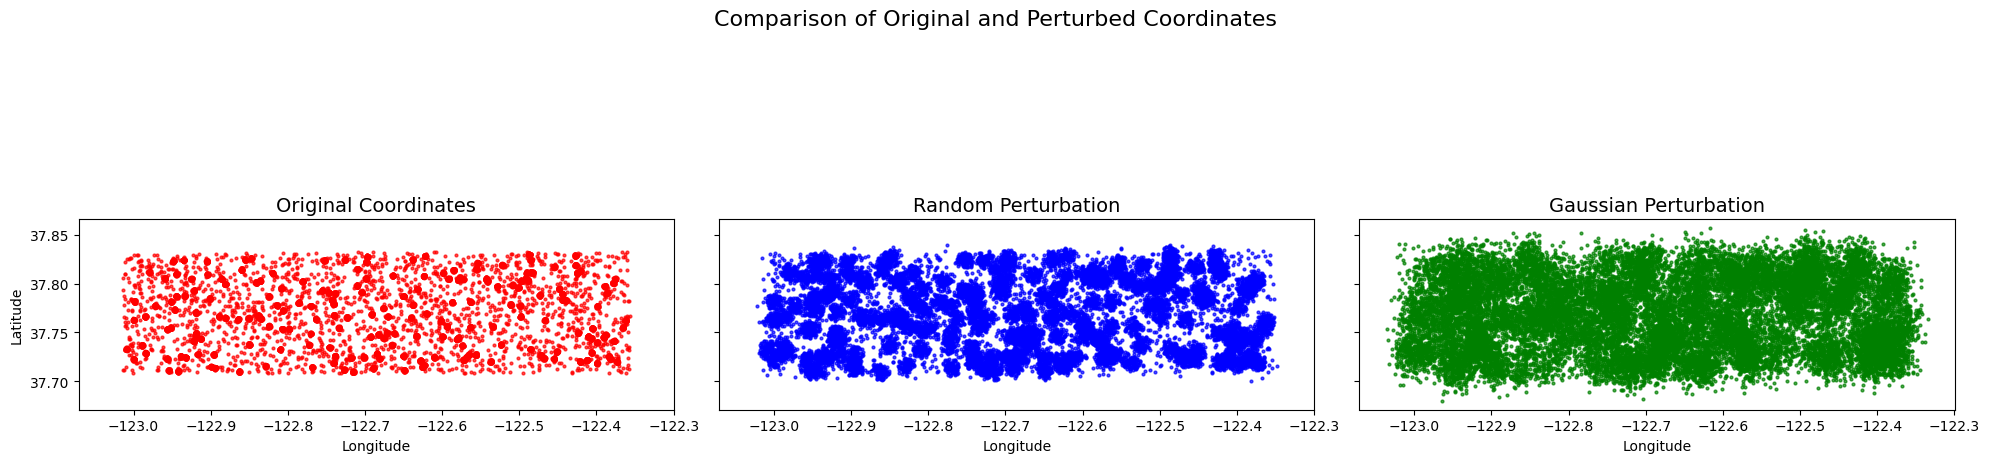

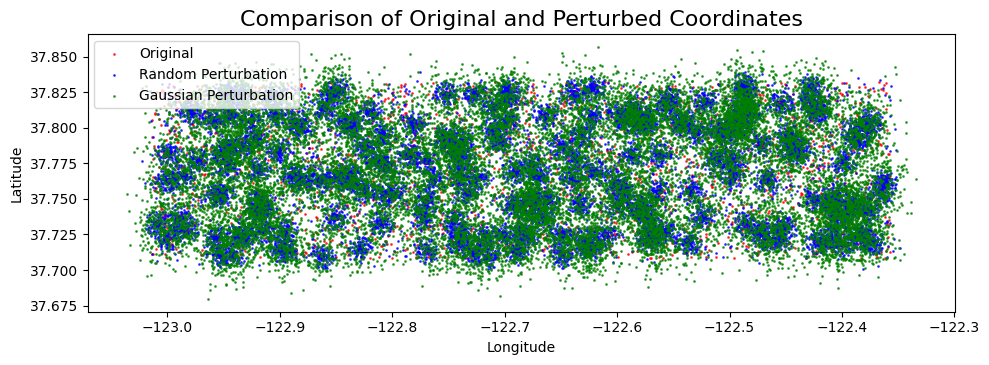

In [5]:
import ast

file_path = 'tweets.csv'
results_df = pd.read_csv(file_path)

results_df=apply_geomasking(results_df)

# # Convert string representations of lists and tuples to actual Python objects
# results_df['RandomPerturbedLatLon'] = results_df['RandomPerturbedLatLon'].apply(ast.literal_eval)
# results_df['GaussianPerturbedLatLon'] = results_df['GaussianPerturbedLatLon'].apply(ast.literal_eval)

# Prepare the dataset with original, random, and Gaussian perturbed coordinates as GeoDataFrames
original_geometry = [Point(xy[1], xy[0]) for xy in zip(results_df['Latitude'], results_df['Longitude'])]
random_geometry = [Point(xy[1], xy[0]) for xy in results_df['RandomPerturbedLatLon']]
gaussian_geometry = [Point(xy[1], xy[0]) for xy in results_df['GaussianPerturbedLatLon']]

original_gdf = gpd.GeoDataFrame(results_df, geometry=original_geometry, crs="EPSG:4326")
random_gdf = gpd.GeoDataFrame(results_df, geometry=random_geometry, crs="EPSG:4326")
gaussian_gdf = gpd.GeoDataFrame(results_df, geometry=gaussian_geometry, crs="EPSG:4326")

# # Plot the original and perturbed data
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# Original Coordinates
original_gdf.plot(ax=ax[0], color='red', alpha=0.7, markersize=4)
ax[0].set_title("Original Coordinates", fontsize=14)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# # Random Perturbation
random_gdf.plot(ax=ax[1], color='blue', alpha=0.7, markersize=4)
ax[1].set_title("Random Perturbation", fontsize=14)
ax[1].set_xlabel('Longitude')

# # Gaussian Perturbation
gaussian_gdf.plot(ax=ax[2], color='green', alpha=0.7, markersize=4)
ax[2].set_title("Gaussian Perturbation", fontsize=14)
ax[2].set_xlabel('Longitude')

plt.suptitle('Comparison of Original and Perturbed Coordinates', fontsize=16)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))

# # Plot all points in the same plot with different colors
original_gdf.plot(ax=plt.gca(), color='red', alpha=0.7, markersize=1, label='Original')
random_gdf.plot(ax=plt.gca(), color='blue', alpha=0.7, markersize=1, label='Random Perturbation')
gaussian_gdf.plot(ax=plt.gca(), color='green', alpha=0.7, markersize=1, label='Gaussian Perturbation')

# Set plot title and labels
plt.title('Comparison of Original and Perturbed Coordinates', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# # Add legend to the plot
plt.legend()

# # Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import coords
files =["rp_1_tweets","rp_2_tweets"]

eps = [i for i in range(50,1000,50)]

for file in files:
    coords.analyze(file,eps)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


     eps  min_samples  median_home_accuracy  mean_home_accuracy   
118  950            4              0.986364            0.949545  \
119  950            5              0.981818            0.947409   
122  950            8              0.972727            0.946864   
110  900            4              0.981818            0.946409   
121  950            7              0.977273            0.945773   
..   ...          ...                   ...                 ...   
2    150            5              0.545455            0.547203   
7    200            7              0.545455            0.545455   
13   250            9              0.545455            0.545455   
21   300           11              0.545455            0.545455   
3    150            6              0.545455            0.545455   

     median_work_accuracy  mean_work_accuracy  mean_home_precision   
118              0.986364            0.945591             0.949545  \
119              0.981818            0.943364          

In [7]:
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import ast

def label_tweets_by_voronoi(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    required_cols = ['User', 'Latitude', 'Longitude', 'User_home', 'User_work']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")

    def parse_lat_lon(s):
        coords = ast.literal_eval(s)
        return coords[0], coords[1]

    labeled_dfs = []

    # Group by user
    for user_id, group_df in df.groupby('User'):
        unique_home_work = group_df[['User_home', 'User_work']].drop_duplicates()
        
        # WARNING
        if len(unique_home_work) > 1:
            print(f"WARNING: user_id {user_id} has multiple distinct home/work pairs.")
            unique_home_work = unique_home_work.iloc[[0]]
        
        home_str = unique_home_work['User_home'].values[0]
        work_str = unique_home_work['User_work'].values[0]
        
        home_lat, home_lon = parse_lat_lon(home_str)
        work_lat, work_lon = parse_lat_lon(work_str)
        
        # Add dummy points to make Voronoi work
        dummy_point1 = [home_lat + 1, home_lon + 1]
        dummy_point2 = [work_lat - 1, work_lon - 1]
        
        centers = np.array([
            [home_lat, home_lon],
            [work_lat, work_lon],
            dummy_point1,
            dummy_point2
        ])
        
        # Generate the Voronoi diagram
        vor = Voronoi(centers)
        
        #labeling
        def assign_home_or_work(row):
            point = np.array([row['Latitude'], row['Longitude']])
            dists = np.sqrt(np.sum((centers[:2] - point)**2, axis=1))
            return 'home' if np.argmin(dists) == 0 else 'work'
        
        group_df['VoronoiLabel'] = group_df.apply(assign_home_or_work, axis=1)
        labeled_dfs.append(group_df)

    labeled_df = pd.concat(labeled_dfs, axis=0)
    labeled_df.to_csv(output_csv, index=False)
    print(f"Done! Labeled tweets saved in '{output_csv}'.")

label_tweets_by_voronoi("tweets.csv", "labeled_tweets_voronoi.csv")

Done! Labeled tweets saved in 'labeled_tweets_voronoi.csv'.


Geomasking based on density population of district in San Francisco

In [8]:

import geopandas as gpd


# Convert the dataset into a GeoDataFrame for spatial operations
tweets_gdf = gpd.GeoDataFrame(
    tweets_df,
    geometry=gpd.points_from_xy(tweets_df['Longitude'], tweets_df['Latitude']),
    crs="EPSG:4326"  # WGS84 coordinate system
)


def estimate_population_density(latitude, longitude):
    # Approximate densities in persons per square kilometer for neighborhoods in San Francisco
    neighborhoods = [
        {"name": "Downtown", "lat": 37.7749, "lon": -122.4194, "density": 7000},  # Example density
        {"name": "Mission District", "lat": 37.7599, "lon": -122.4148, "density": 6000},
        {"name": "Outer Sunset", "lat": 37.7534, "lon": -122.4944, "density": 3000},
        {"name": "Richmond District", "lat": 37.7802, "lon": -122.4837, "density": 4000},
    ]

    #Default to a minimum density if far from all neighborhoods
    base_density = 100
    density = base_density

    #Calculate the density based on proximity to neighborhoods
    for area in neighborhoods:
        distance = np.sqrt((latitude - area["lat"])**2 + (longitude - area["lon"])**2)
        # Exponential decay in which closer neighborhoods have a stronger influence
        density += area["density"] * np.exp(-distance / 0.01)

    return density

# Estimate population density for each tweet location
tweets_gdf['PopulationDensity'] = tweets_gdf.apply(
    lambda row: estimate_population_density(row['Latitude'], row['Longitude']),
    axis=1
)

# Apply population-density-based geomasking
def geomask(lat, lon, pop_density,shift):
    # Define the scaling constant for perturbation distance
    C = shift  # Controls maximum shift
    shift_distance = C / np.sqrt(pop_density)
    random_angle = np.random.uniform(0, 2 * np.pi)

    # Compute new latitude and longitude
    new_lat = lat + shift_distance * np.cos(random_angle)
    new_lon = lon + shift_distance * np.sin(random_angle) / np.cos(np.radians(lat))
    return new_lat, new_lon

# Apply geomasking to each point
tweets_gdf[['MaskedLatitude', 'MaskedLongitude']] = tweets_gdf.apply(
    lambda row: geomask(row['Latitude'], row['Longitude'], row['PopulationDensity'], 0.01),
    axis=1, result_type='expand'
)

# Save the updated dataset
tweets_gdf[['TweetID', 'Latitude', 'Longitude', 'MaskedLatitude', 'MaskedLongitude', 'PopulationDensity']].to_csv(
    "masked_tweets.csv", index=False
)

# Display the updated results
print(tweets_gdf[['TweetID', 'Latitude', 'Longitude', 'MaskedLatitude', 'MaskedLongitude', 'PopulationDensity']].head())


  TweetID   Latitude   Longitude  MaskedLatitude  MaskedLongitude   
0      t0  37.815903 -122.554599       37.816866      -122.554895  \
1      t1  37.814489 -122.553782       37.815274      -122.554545   
2      t2  37.815015 -122.555740       37.815995      -122.555927   
3      t3  37.815809 -122.554942       37.816698      -122.555495   
4      t4  37.814827 -122.555672       37.814666      -122.556910   

   PopulationDensity  
0         101.945201  
1         102.241916  
2         101.849279  
3         101.899192  
4         101.877761  


Visualize the results for 100 random samples

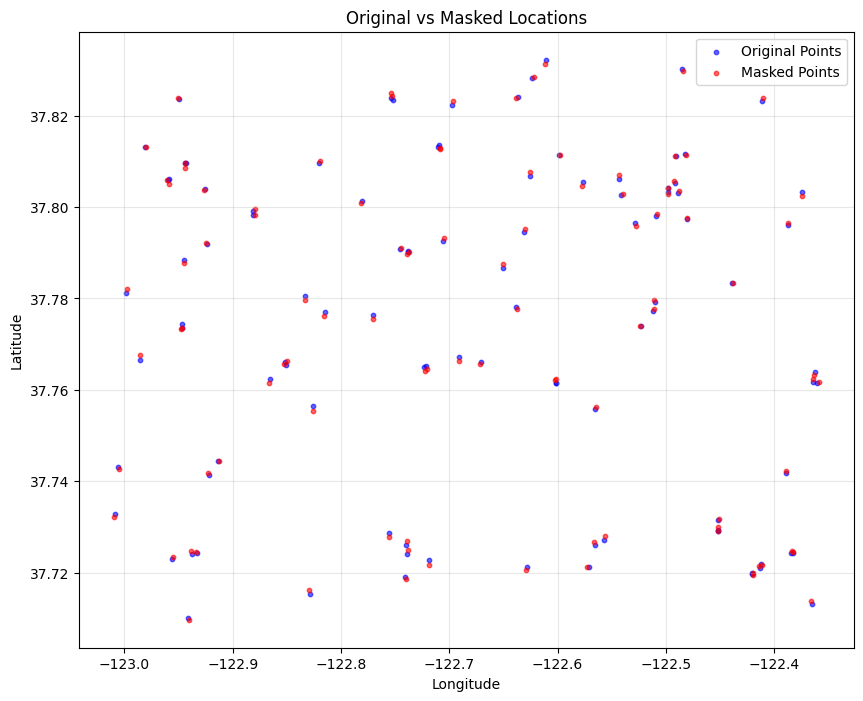

In [9]:
import matplotlib.pyplot as plt

original_coords = tweets_gdf[['Longitude', 'Latitude']]
masked_coords = tweets_gdf[['MaskedLongitude', 'MaskedLatitude']]

# Sample 100 points from the dataset
sampled_original_coords = original_coords.sample(n=100, random_state=42)
sampled_masked_coords = masked_coords.sample(n=100, random_state=42)

# Plot the points
plt.figure(figsize=(10, 8))
plt.scatter(sampled_original_coords['Longitude'], sampled_original_coords['Latitude'], color='blue', label='Original Points', alpha=0.6, s=10)
plt.scatter(sampled_masked_coords['MaskedLongitude'], sampled_masked_coords['MaskedLatitude'], color='red', label='Masked Points', alpha=0.6, s=10)

# Add labels and legend
plt.title('Original vs Masked Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [10]:
def custom_geomask(row,shift):
    curr_lat = row['Latitude']
    curr_long = row['Longitude']
    new_lat,new_long = geomask(curr_lat,curr_long,row['PopulationDensity'],shift)
    row["Latitude"] = new_lat
    row["Longitude"] = new_long
    return row

file_path = 'tweets.csv'  
tweets = pd.read_csv(file_path)
tweets['PopulationDensity'] = tweets.apply(
    lambda row: estimate_population_density(row['Latitude'], row['Longitude']),
    axis=1
)

new_dataset01=tweets.apply(custom_geomask,shift=0.1,axis=1)
new_dataset05=tweets.apply(custom_geomask,shift=0.05,axis=1)
new_dataset001=tweets.apply(custom_geomask,shift=0.01,axis=1)


save_results(new_dataset01,"custom_tweets01.csv")
save_results(new_dataset05,"custom_tweets05.csv")
save_results(new_dataset001,"custom_tweets001.csv")


In [11]:
import coords

files = ["custom_tweets01","custom_tweets05","custom_tweets001"]
for file in files:
    coords.analyze(file,[i for i in range(50,1000,50)])

    eps  min_samples  median_home_accuracy  mean_home_accuracy   
80  550            7              1.000000            0.976955  \
79  550            6              1.000000            0.976955   
78  550            5              1.000000            0.976955   
77  550            4              1.000000            0.976955   
81  550            8              1.000000            0.976182   
..  ...          ...                   ...                 ...   
12  100           11              0.545455            0.544886   
1    50            5              0.545455            0.544545   
11  100           10              0.545455            0.544091   
8   100            7              0.545455            0.541860   
9   100            8              0.545455            0.534416   

    median_work_accuracy  mean_work_accuracy  mean_home_precision   
80              1.000000            0.966045             0.976955  \
79              1.000000            0.967364             0.976955   
